In [272]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib.colors as colors

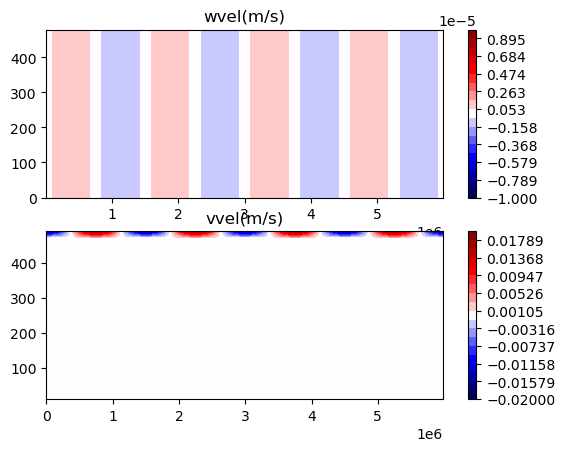

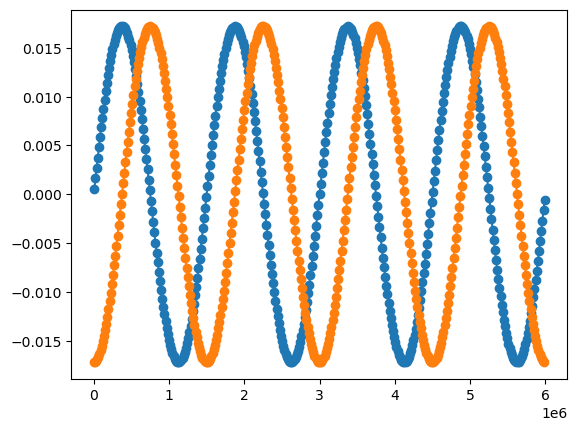

In [514]:
Ny=400 #Number of grids
Nz=25  #Number of grids
Ly=6000000 #in meters
Lz=500 #in meters
ygrid=np.linspace(0,Ly,Ny)
zgrid=np.linspace(0,Lz,Nz)





basin_width=28000000 #km



ygridt=(ygrid[1:]+ygrid[:-1])/2
zgridt=(zgrid[1:]+zgrid[:-1])/2
ygridu=ygrid[:-1] #v surface,at the negative(south) side of the t grid
zgridu=zgrid[:-1] #w surface,at the negative(top) side of the t grid
dy=ygrid[1]-ygrid[0]
dz=zgrid[1]-zgrid[0]

Nk=4 #numbers of "waves" in w
alpha=1/(Ly)*2*np.pi*Nk #w= Asin(alpha y)
A=1.5e-6
wsin=A*np.sin((ygridt)*alpha)
wsin2D=np.tile(wsin,[Nz,1])
#wsin2D[40:,:]=0


v2d=wsin2D.T[:,:-1]*0
w2d=wsin2D.T[:,:-1]*1

# plt.contourf(ygrid,zgrid,wsin2D)
# plt.colorbar()

vgrid=-A/alpha/dz*np.cos(alpha*ygridu)

v2d[:,-1]=vgrid

plt.figure()
plt.subplot(2,1,1)
plt.title('wvel(m/s)')
plt.contourf(ygridt,zgridu,w2d.T,levels=np.linspace(-10,10,20)*1e-6,cmap='seismic')
plt.colorbar()
plt.subplot(2,1,2)
plt.contourf(ygridu,zgridt,v2d.T,levels=np.linspace(-0.02,0.02,20),cmap='seismic')
plt.title('vvel(m/s)')
plt.colorbar()

plt.figure()
plt.plot(np.squeeze(ygridt),np.squeeze(w2d[:,-1])/alpha/dz,'o-')
plt.plot(np.squeeze(ygridu),np.squeeze(vgrid),'-o')

In [515]:
Nyt=Ny-1
Nzt=Nz-1
v_basin_grid=v2d
w_basin_grid=w2d

kdia=5e-5
kiso=1000

#dt=86400*10#s
#T=31104000*300#00#31104000*5000 #years->second
dt=8640*2
T=31104000*100
Nt=T//dt
#Nt=40000
kiso=1000#-500#m2/s
#kv=kv0
#kdia=0
tracer=np.zeros([Nyt,Nzt])
#tracer[0,:]=np.linspace(0,400*31104000,Nz)
tracer_source=np.ones([Nyt,Nzt])
tracer_yface=np.zeros([Nyt,Nzt])
tracer_zface=np.zeros([Nyt,Nzt])
grad_y=np.zeros([Nyt,Nzt])
grad_z=np.zeros([Nyt,Nzt])
advy_1=np.zeros([Nyt,Nzt])
advy_2=np.zeros([Nyt,Nzt])
advz_1=np.zeros([Nyt,Nzt])
advz_2=np.zeros([Nyt,Nzt])
##write a 2D solver here


for it in range(0,Nt):
    ##advection: using centered 2nd order scheme
    #tracer_yface[1:,:]=(tracer[:-1,:]+tracer[1:,:])/2 #v surface is at the negative(south) side of the t grid
    #advy=v_basin_grid*tracer_yface
    #tracer_zface[:,:-1]=(tracer[:,:-1]+tracer[:,1:])/2 #w surface is at the top of t grid
    
    #advection:upwind
    #advy is on the negative side of t grid
    #advy_1: contribution from the negative side of t grid
    advy_1[1:,:]=np.where(v_basin_grid[1:,:]>0, tracer[:-1,:]*v_basin_grid[1:,:],0)
    advy_1[0,:]=np.where(v_basin_grid[0,:]>0, tracer[-1,:]*v_basin_grid[0,:],0)
    #advy_2: contribution from the positive side of t grid
    advy_2=np.where(v_basin_grid<0, tracer*v_basin_grid,0)
    advy=advy_1+advy_2
    #advz is on the top side of the t grid
    #advz_1: contribution from the bottom side of t grid
    advz_1=np.where(w_basin_grid>0,tracer*w_basin_grid,0)
    #advz_2:contribution from the top side of t grid
    advz_2[:,1:]=np.where(w_basin_grid[:,1:]<0,tracer[:,:-1]*w_basin_grid[:,1:],0)
    advz=advz_1+advz_2
    
    grad_y[1:,:]=(tracer[1:,:]-tracer[:-1,:])/dy
    grad_y[0,:]=(tracer[0,:]-tracer[-1,:])/dy
    grad_z[:,1:]=(tracer[:,1:]-tracer[:,:-1])/dz #w grid is on the upper Z surface

    diffy=-kiso*grad_y
    diffz=-kdia*grad_z

    fluxy=advy+diffy 
    fluxz=advz+diffz
    
    tracertop=tracer[:,-1]
    tracertop.shape=(Ny-1,1)
    fluxy=np.vstack((fluxy,fluxy[0,:]))
    fluxz=np.hstack((fluxz,0*kdia*tracertop/dz))
    tracer[:,1:]=tracer[:,1:]+dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)+tracer_source[:,1:])
    tracer[:,1:]=tracer[:,1:]+dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)+tracer_source[:,1:])




Text(0.5, 1.0, 'KH=1000,Nk=4,Aw=1.5e-06,kdia=5e-05')

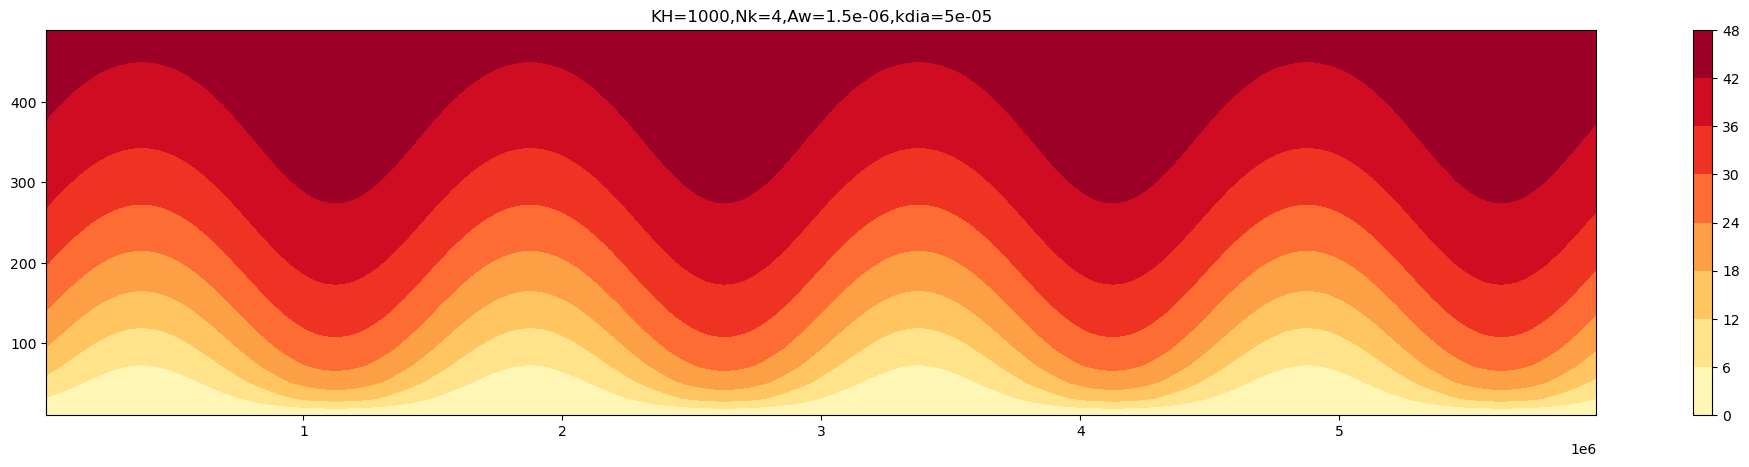

In [516]:
age=tracer
age_source=np.ones([Nyt,Nzt])
plt.figure(figsize=(25,5))
plt.contourf(ygridt,zgridt,age.T/31104000,cmap=plt.cm.YlOrRd)
plt.colorbar()
plt.title(f"KH={kiso},Nk={Nk},Aw={A},kdia={kdia}")

In [ ]:
def tracer_integrate(Nyt,Nzt,tracer_init,tracer_source,dt=86400*10,T=31104000*1000):
    """
    integrate tracers
    Nyt,Nzt:number of grids
    tracer_init: initial tracer concentration
    tracer_source: source term for tracer
    """
    advy_1=np.zeros([Nyt,Nzt])
    advy_2=np.zeros([Nyt,Nzt])
    advz_1=np.zeros([Nyt,Nzt])
    advz_2=np.zeros([Nyt,Nzt])
    grad_y=np.zeros([Nyt,Nzt])
    grad_z=np.zeros([Nyt,Nzt])
    tendency=np.zeros([Nyt,Nzt])
    ten_ydiff=np.zeros([Nyt,Nzt])
    ten_zdiff=np.zeros([Nyt,Nzt])
    ten_yadv=np.zeros([Nyt,Nzt])
    ten_zadv=np.zeros([Nyt,Nzt])
    
    
    
    Nt=T//dt
    kdia=1e-4
    kiso=500
    
    tracer=np.copy(tracer_init)
    for it in range(0,Nt):
        ##advection: using centered 2nd order scheme
        tracer_yface[1:,:]=(tracer[:-1,:]+tracer[1:,:])/2 #v surface is at the negative(south) side of the t grid
        advy=v_basin_grid*tracer_yface
        tracer_zface[:,1:]=(tracer[:,:-1]+tracer[:,1:])/2 #w surface is at the top of t grid
        advz=w_basin_grid*tracer_zface
#         #advection:upwind
#         #advy is on the negative side of t grid
#         #advy_1: contribution from the negative side of t grid
#         advy_1[1:,:]=np.where(v_basin_grid[1:,:]>0, tracer[:-1,:]*v_basin_grid[1:,:],0)
#         #advy_2: contribution from the positive side of t grid
#         advy_2=np.where(v_basin_grid<0, tracer*v_basin_grid,0)
#         advy=advy_1+advy_2
#         #advz is on the top side of the t grid
#         #advz_1: contribution from the bottom side of t grid
#         advz_1=np.where(w_basin_grid>0,tracer*w_basin_grid,0)
#         #advz_2:contribution from the top side of t grid
#         advz_2[:,1:]=np.where(w_basin_grid[:,1:]<0,tracer[:,:-1]*w_basin_grid[:,1:],0)
#         advz=advz_1+advz_2

        grad_y[1:,:]=(tracer[1:,:]-tracer[:-1,:])/dy
        grad_z[:,1:]=(tracer[:,1:]-tracer[:,:-1])/(dz) #w grid is on the upper Z surface

        diffy=-kiso*grad_y
        diffz=-kdia*grad_z

        fluxy=advy+diffy 
        fluxz=advz+diffz
        
        fluxy=np.vstack((fluxy,np.zeros([1,Nzt])))
        fluxz=np.hstack((fluxz,np.zeros([Nyt,1])))
        
        diffy=np.vstack((diffy,np.zeros([1,Nzt])))
        diffz=np.hstack((diffz,np.zeros([Nyt,1])))
        
        advy=np.vstack((advy,np.zeros([1,Nzt])))
        advz=np.hstack((advz,np.zeros([Nyt,1])))
        tracer[:,1:]=tracer[:,1:]+dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)+tracer_source[:,1:])
        #tracer[:,1:]=tracer[:,1:]+0*dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz))
        
#         tendency[:,1:]=dt*((-fluxy[1:,1:]+fluxy[:-1,1:])/dy+(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)+tracer_source[:,1:])
#         ten_ydiff[:,1:]=dt*(-diffy[1:,1:]+diffy[:-1,1:])/dy
#         ten_zdiff[:,1:]=dt*(-fluxz[:,1:-1]+fluxz[:,2:])/(-dz)
#         ten_yadv[:,1:]=dt*(-advy[1:,1:]+advy[:-1,1:])/dy
#         ten_zadv[:,1:]=dt*(-advz[:,1:-1]+advz[:,2:])/(-dz)
    return tracer#,tendency,ten_ydiff,ten_zdiff,ten_yadv,ten_zadv
    
    

In [402]:
age_out=tracer_integrate(Nyt=Nyt,Nzt=Nzt,tracer_init=age,tracer_source=age_source,dt=864000,T=31104000000)
age2_out=tracer_integrate(Nyt=Nyt,Nzt=Nzt,tracer_init=age*0,tracer_source=age_source*2,dt=864000,T=31104000000)

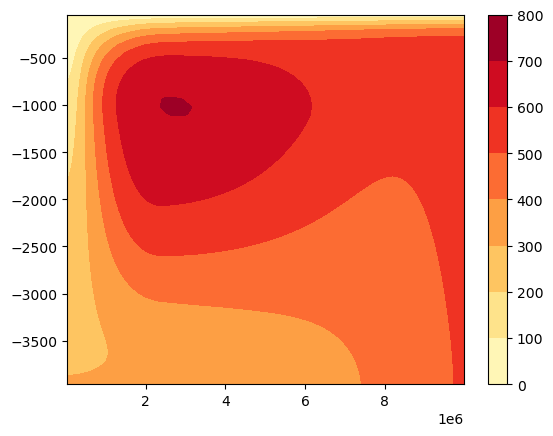

In [407]:
plt.contourf(ygridt,zgridt,age2_out.T/31104000,cmap=plt.cm.YlOrRd)
plt.colorbar()

In [389]:
lat_tracer=np.zeros([Nyt,Nzt])
lat_tracer[:,0]=ygridt
lat_out=tracer_integrate(Nyt=Nyt,Nzt=Nzt,tracer_init=lat_tracer,tracer_source=age_source*0,
                         dt=864000,T=31104000*500)

# plt.figure()
# plt.contourf(ygridt,zgridt,ten_ydiff.T,cmap=plt.cm.YlOrRd)
# plt.colorbar()
# plt.figure()
# plt.contourf(ygridt,zgridt,ten_zdiff.T,cmap=plt.cm.YlOrRd)
# plt.colorbar()
# plt.figure()
# plt.contourf(ygridt,zgridt,ten_yadv.T,cmap=plt.cm.YlOrRd)
# plt.colorbar()
# plt.figure()
# plt.contourf(ygridt,zgridt,ten_zadv.T,cmap=plt.cm.YlOrRd)
# plt.colorbar()


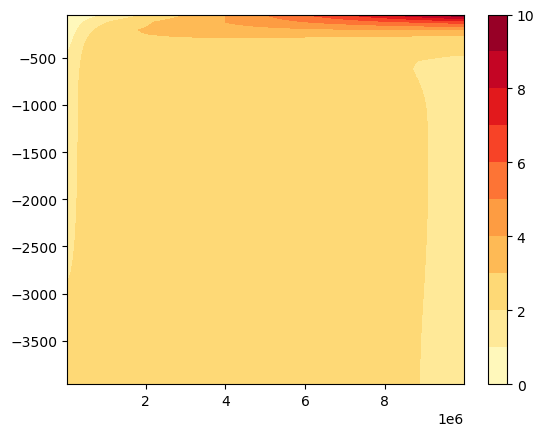

In [394]:
plt.contourf(ygridt,zgridt,lat_out.T/1e6,cmap=plt.cm.YlOrRd,levels=np.linspace(0,10,11))
plt.colorbar()

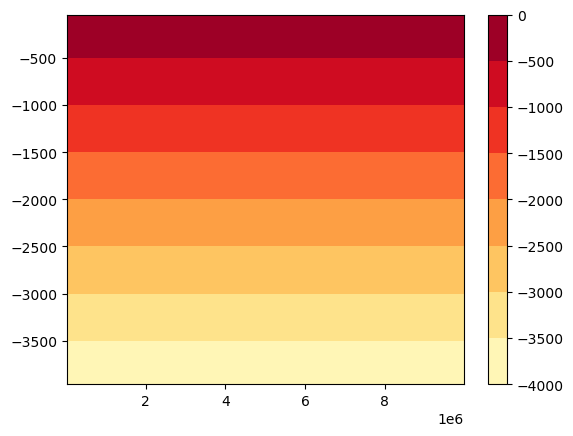

In [428]:
[ygridt2d,zgridt2d]=np.meshgrid(ygridt,zgridt)
ygridt2d=ygridt2d.T
zgridt2d=zgridt2d.T
plt.contourf(ygridt,zgridt,zgridt2d.T,cmap=plt.cm.YlOrRd)
plt.colorbar()

In [437]:
def x_norm(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))
    

Text(0.5, 1.0, 'SurfYOrigin-age relationship')

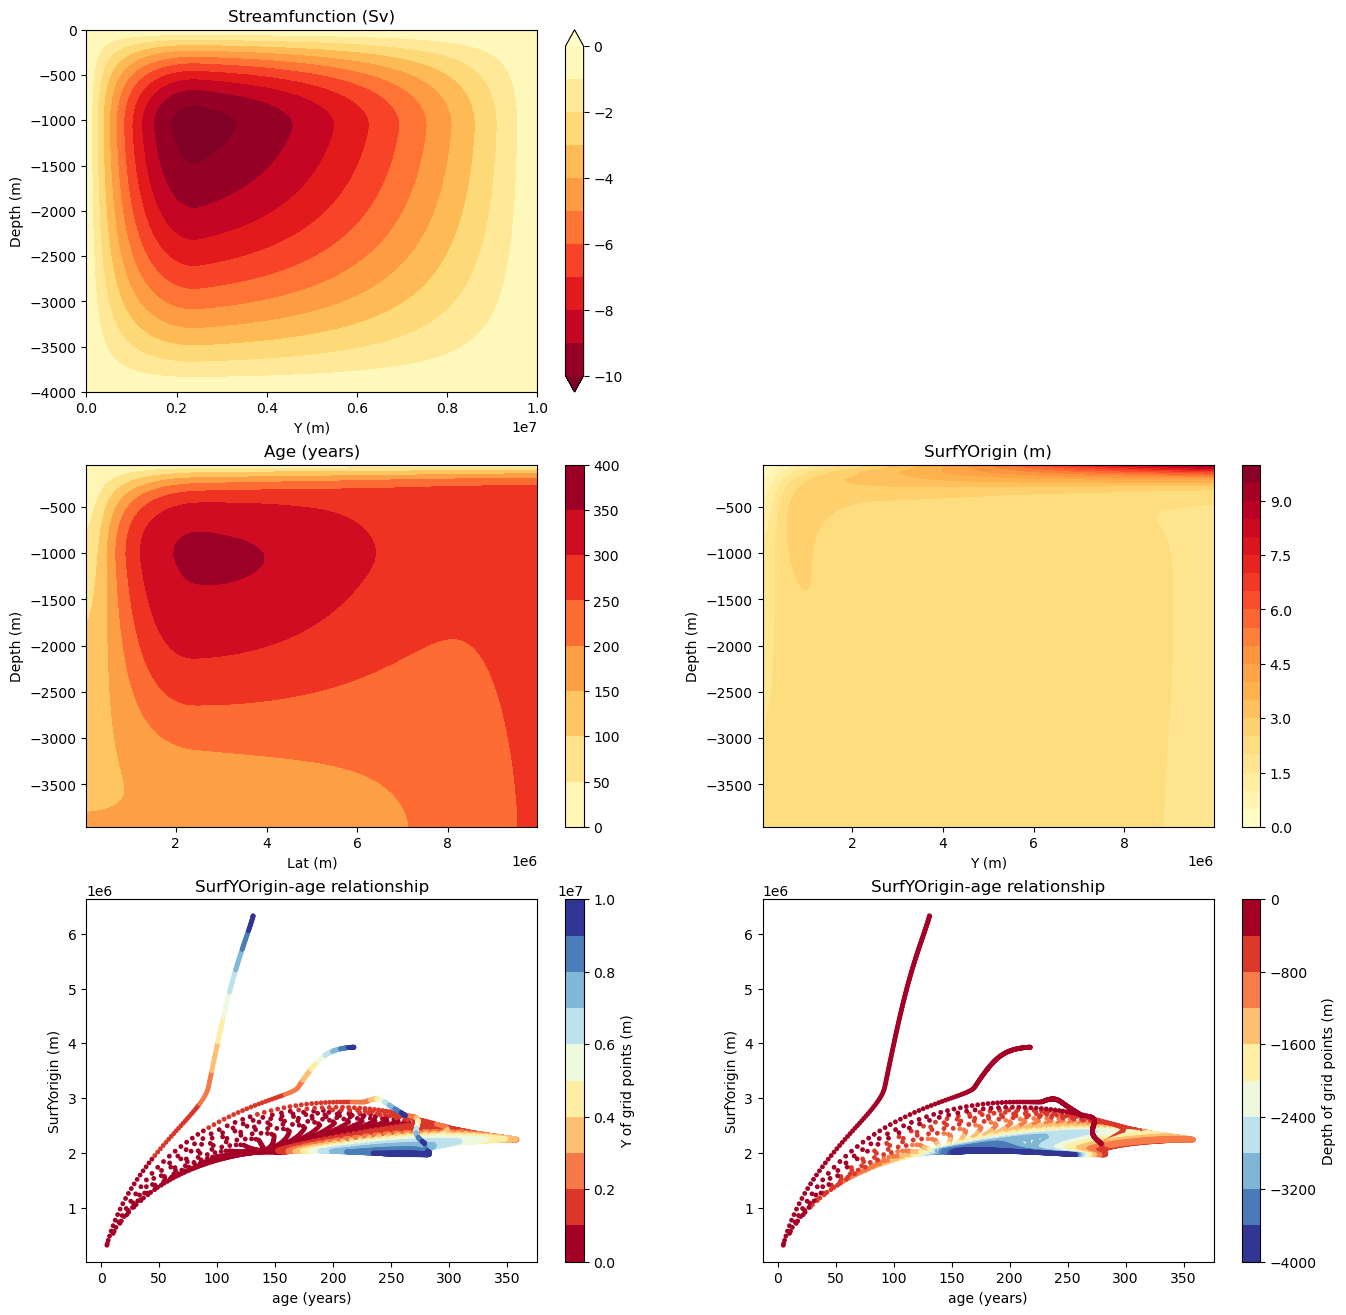

In [583]:
jump=1
alpha0=0.5
zcarray=zgridt2d[:,1::jump].flatten()
ycarray=ygridt2d[:,1::jump].flatten()
znorm = colors.BoundaryNorm(boundaries=np.linspace(-4000,0,11),ncolors=256)
ynorm=colors.BoundaryNorm(boundaries=np.linspace(0,1e7,11),ncolors=256)
plt.figure(figsize=(16,16))
plt.subplot(3,2,1)
plt.contourf(xgrid,zgrid,Psi2d.T,extend='both',levels=np.linspace(-10,0,11),cmap=plt.cm.YlOrRd.reversed())
plt.colorbar()
plt.title('Streamfunction (Sv)')
plt.xlabel('Y (m)')
plt.ylabel('Depth (m)')
plt.subplot(3,2,3)
plt.contourf(ygridt,zgridt,age_out.T/31104000,cmap=plt.cm.YlOrRd)
cbar=plt.colorbar()
plt.title('Age (years)')
plt.xlabel('Lat (m)')
plt.ylabel('Depth (m)')
plt.subplot(3,2,4)
plt.contourf(ygridt,zgridt,lat_out.T/1e6,cmap=plt.cm.YlOrRd,levels=np.linspace(0,10,21))
plt.colorbar()
plt.xlabel('Y (m)')
plt.ylabel('Depth (m)')
plt.title('SurfYOrigin (m)')
plt.subplot(3,2,5)
#plt.scatter(age_out[:,1::jump].flatten()/31104000,lat_out[:,1::jump].flatten(),s=6,c=ycarray,alpha=1,norm=norm,cmap=plt.cm.YlOrRd)
plt.scatter(age_out[:,1::jump].flatten()/31104000,lat_out[:,1::jump].flatten(),s=6,c=ycarray,alpha=1,norm=ynorm,cmap=plt.cm.RdYlBu)
cbar=plt.colorbar()
cbar.set_label('Y of grid points (m)')
plt.xlabel('age (years)')
plt.ylabel('SurfYorigin (m)')
plt.title('SurfYOrigin-age relationship')
plt.subplot(3,2,6)
#plt.scatter(age_out[:,1::jump].flatten()/31104000,lat_out[:,1::jump].flatten(),s=6,c=ycarray,alpha=1,norm=norm,cmap=plt.cm.YlOrRd)
plt.scatter(age_out[:,1::jump].flatten()/31104000,lat_out[:,1::jump].flatten(),s=6,c=zcarray,alpha=1,norm=znorm,cmap=plt.cm.RdYlBu.reversed())
cbar=plt.colorbar()
cbar.set_label('Depth of grid points (m)')
plt.xlabel('age (years)')
plt.ylabel('SurfYorigin (m)')
plt.title('SurfYOrigin-age relationship')

In [453]:

age_out[:,1::3].flatten().shape

(3184,)

In [481]:
carray

array([ -122.44897959,  -530.6122449 ,  -938.7755102 , ...,
       -2979.59183673, -3387.75510204, -3795.91836735])

Text(0.5, 1.0, 'age vs age2x')

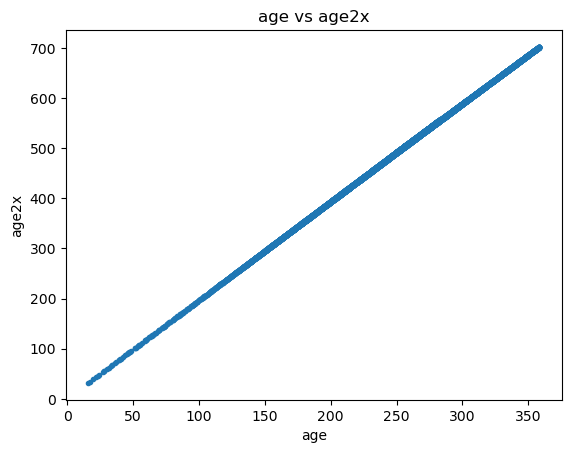

In [413]:
plt.plot(age_out[:,3:].flatten()/31104000,age2_out[:,3:].flatten()/31104000,'.')
plt.xlabel('age')
plt.ylabel('age2x')
plt.title('age vs age2x')

In [484]:
norm(10)

120